<a href="https://colab.research.google.com/github/tdushio/shiolabOpen/blob/master/31_LMI%E3%81%AB%E3%82%88%E3%82%8B%E5%80%92%E7%AB%8B%E6%8C%AF%E5%AD%90%E3%81%AE%E5%AE%89%E5%AE%9A%E5%8C%96%E5%88%B6%E5%BE%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 31.LMIによる倒立振子の安定化制御

※これは Qiitaで紹介された記事
「Python使って、LMIを解いて、倒立振り子の状態フィードバック制御器を設計する」
：https://qiita.com/R-second/items/78fb38dece73db13b834　をもとに汐月がアレンジしたスクリプトです。



ここからが Qiitaの掲載記事の内容です
# 概要

<A href="https://www.morikita.co.jp/books/mid/092101" target="_blank">
『LMIによるシステム制御 ロバスト制御系設計のための体系的アプローチ』 (蛯原義雄, 森北出版)</A>の1章の問題をPython(cvxpy)で実装してみた.

この記事で得られること：
<ul>
<li> Pythonを用いて、線形行列不等式(LMI; Linear Matrix Inequality)を解く.</li>
<li> Pythonを用いて、制御器を設計し、倒立振り子の数値シミュレーションを行う.</li>
<li> 具体的な例を通して、cvxpyの使い方をまとめる.</li>
</ul>

## 記事の目的
PythonでLMIを解くときには、限られた選択肢しかない.(参考：PythonのSDP実行時間比較)
さらに、困ったことに、cvxpyでLMIを解く日本語の記事がほっっとんどない.
そのため、<A href="https://www.cvxpy.org/index.html">cvxpy 公式ドキュメント</A>を読んで、試行錯誤...
その結果を、今後のためにも備忘録的にまとめておくことにした.

## 問題設定と求解すべきLMI

## 制御対象のモデル
倒立振子のモデルを
$1$ 入力$4$出力$4$次の線形時不変システム(LTI)で与える。<br>
\begin{equation}
   \dot{x}(t) = A x(t) + B u(t) , \;
    y(t) = C x(t),\;\; x(0)=x_0  \nonumber
\end{equation}
ここで、状態$x(t)\in{\mathrm R}^4$は
$x=[z,\theta,\dot{z},\dot{\theta}]^\top$、
$u(t)\in{\mathrm R}$はモータへの入力である。
$x_0\in{\mathrm R}^4$は初期状態を表す。

(詳しいパラメータの意味や値は本質的ではないので、ここでは割愛)

## 制御の目的

この制御対象に対し、<br>
<ol>
<li>閉ループシステムを安定化する</li>
<li>初期状態が平衡状態からずれていても、すみやかに平衡状態に整定する</li>
<li>角度が $\pi/36$ rad から制御を開始した時の制御入力の振幅が1.2を超えない (初期状態が $ x(0) = B_{w_2}=[0.\pi/36,0,0]$ から制御を開始したとき)
という要件を満たす状態フィードバック制御器  $u = -Kx$  を設計する.</li>
</ol>

## ＜解説＞
制御目的は、時間応答波形の特徴で定量的に定義されている。<br>
制御手法は、状態フィードバックを選択している<br>
制御器設計手法は、LMIを採用している<br>
LMIとは、線形行列不等式(Linear Matrix Inequality)を拘束条件とする最適化問題の解法

# LMI

設計仕様を定式化すると、次のLMIを満たす $X,Y$ を求め、
$K=YX^{-1}$ で定めればよい.(導出は参考文献の本をご確認ください)
\begin{equation}
\left[ \begin{array}{cc}
    \mathrm{He}(AX+BY) & * \\ C_{z2}X+D_{z2u}Y & -\gamma I_5
  \end{array} \right] \prec 0,\;\;
\left[ \begin{array}{cc}
    X & * \\ B_{w2} &1
  \end{array} \right] \succ 0,\;\;
\left[ \begin{array}{cc}
    X & * \\ Y & 1.2^2
  \end{array} \right] \succ 0,\;\;  
\end{equation}
ただし、$C_{z2}, D_{z2u}$ は以下。
\begin{equation}
C_{z2}=[I_4\;O_{4,1}]^\top,\;\; D_{z2u}=[0_{1,4}\; 1]^\top
\end{equation}
また、$\mathrm{He}(A)=A+A^\top$
である.

実際に求解する際には、上のLMIを制約として、$\gamma$
を最小化する半正定値計画問題を解くことになる.

# モジュールのインストール
以下のライブラリを使用する。


*   numpy
*   matplotlib
*   control (制御工学ライブラリ)
*   cvxpy (LMIを求解するためのライブラリ)

### <参考>
<A href="https://python-control.readthedocs.io/en/0.10.0/">制御工学モジュール control のドキュメント</a><br>
<A href="https://numpy.org/doc">numpy のドキュメント</A><br>
<A href="https://matplotlib.org/stable/index.html">matplotlib のドキュメント</A><br>
<A href="https://www.cvxpy.org/">cvxpy のドキュメント</A>

In [ ]:
import numpy as np
import cvxpy as cp
# !pip install slycot
!pip install control
from control import matlab   # matlab 互換関数を使用する場合
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.9/513.9 kB 3.4 MB/s eta 0:00:00


# プログラム

1.  状態方程式の作成
2.  LMI条件の作成
3.  求解
4. 制御器の復元
5. シミュレーション




# 制御対象のモデル
倒立振子のモデルを
$1$ 入力$4$出力$4$次の線形時不変システム(LTI)で与える。<br>
\begin{equation}
   \dot{x}(t) = A x(t) + B u(t) , \;
    y(t) = C x(t),\;\; x(0)=x_0  \nonumber
\end{equation}
ここで、$u(t)\in{\mathrm R}$はモータへの入力,
$y(t)\in{\mathrm R}^4$は出力,$x(t)\in{\mathrm R}^4$は状態の時刻$t\in [0,T_f]$での値を成分とする列ベクトルである。<br>
$\dot{x}$は状態$x$の導関数を表す。<br>
$A\in{\mathrm R}^{4\times 4}$,$B\in{\mathrm R}^{4\times 1}$,$C\in{\mathrm R}^{4\times 4}$,$D\in{\mathrm R}^{4\times 1}$は定数行列である.<br>
$x_0\in{\mathrm R}^4$は初期状態を表す。

制御対象に関わる物理量

In [ ]:
l = 0.15             # 振子の長さ
m = 0.0402           # 振子の質量
Jp = 0.00030142      # 振子の慣性モーメント
M = 0.6862           # 台車の質量
Jt = 1.34 * 10**(-4)
Jm = 1.30 * 10**(-7)
Jc = Jt + Jm
r = 0.02485
F = 0.36
c = 0.0015
g = 9.80665
a = 1.9

p = M + m + Jc/(r*r)
q = Jp + m*l*l
W = 1/(p * q - m * m * l * l)


係数行列の作成

In [ ]:
A = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, -m*m*g*l*l*W, -F*q*W, c*m*l*W],
    [0, m*g*l*p*W, F*m*l*W, -c*p*W]
    ])
B = np.array([[0, 0, a*q*W, -a*m*l*W]]).T
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
D = np.zeros((2, 1))

# 今回は使わないが、状態空間の生成は以下
sys = matlab.ss(A, B, C, D)


設計用の制御対象モデルのための係数行列

In [ ]:
Bw2 = np.array([[0, np.pi / 36, 0, 0 ]]).T    # 初期状態
Cz2 = np.array(np.eye(5, 4))     # 対角成分が１. それ以外は0
Dz2u = np.array([[0, 0, 0, 0, 1]]).T

# LMI条件の作成
## 変数宣言
cp.Variable()で、変数の宣言が可能. 第一引数に(必要であれば)行列の型をタプルで渡す.

symmetric=Trueとすると、対称行列であることを条件として課すことができる. (そのほか、nonneg=TrueやPSD=Trueなどがある)

In [ ]:
X = cp.Variable((4, 4), symmetric=True)
Y = cp.Variable((1, 4))
gamma = cp.Variable()

## LMI制約の定義
LMI制約に必要な関数  $\mathrm{He}(A)=A+A^\top$  の定義.

In [ ]:
def He(X):
    return X + X.T

## LMI制約を定義する.

cvxpyの変数を含んだ行列のブロック定義は cp.bmat()で行う.

In [ ]:
M1 = cp.bmat([
    [He(A @ X + B @ Y), (Cz2 @ X + Dz2u @ Y).T],
    [Cz2 @ X + Dz2u @ Y, -gamma * np.eye(5,5) ]
    ])

M2 = cp.bmat([
    [X, Bw2],
    [Bw2.T, np.matrix(1)]
    ])

M3 = cp.bmat([
    [X, Y.T],
    [Y, np.matrix(1.2 * 1.2)]
    ])

# LMI制約の配列
constraints = [ M1 << 0 , M2 >> 0, M3 >> 0]

## 解を求める
cp.Problem()で問題の定義. 第一引数に目的、第二引数に制約を渡す.<br>
cp.Problem().solve()で求解. 求解の詳細が知りたければ、引数としてverbose=Trueを記述しておく.

In [ ]:
prob = cp.Problem(cp.Minimize(gamma), constraints)
# prob.solve()
prob.solve(verbose=True)

以上を実行すると、最小化された
として、0.16157841825111297 が得られる.

## 制御器の復元
制御器は $K=YX^{-1}$ で与えられる.<br>

求解後のcvxpyの変数の値は、変数名.valueで取得できる.

In [ ]:
K = Y.value @ np.linalg.inv(X.value)

# シミュレーション
## 閉ループ系の構成
状態フィードバックをかけたときの閉ループ系は以下で与えられる.
\begin{equation}
   \dot{x}(t) = (A+BK) x(t), \;\;
    y(t) = C x(t),\;\; x(0)=x_0  \nonumber
\end{equation}
これを構成する.

In [ ]:
A_ = A + B @ K
B_ = np.zeros((4, 1))
C_ = C
D_ = D

sys_cl = matlab.ss(A_, B_, C_, D_)       # 状態空間モデル

## 時間応答の観察
matlab.initialで、システムのゼロ入力応答を取得する.

In [ ]:
# 初期値応答
Td = np.arange(0, 10, 0.01)    #シミュレーション時間
# x0 = Bw2                    #初期値
x0 = np.matrix([1,0,0,0]).T
z, t, x = matlab.initial(sys_cl, Td, x0 ,return_x=True)

応答波形を描画する

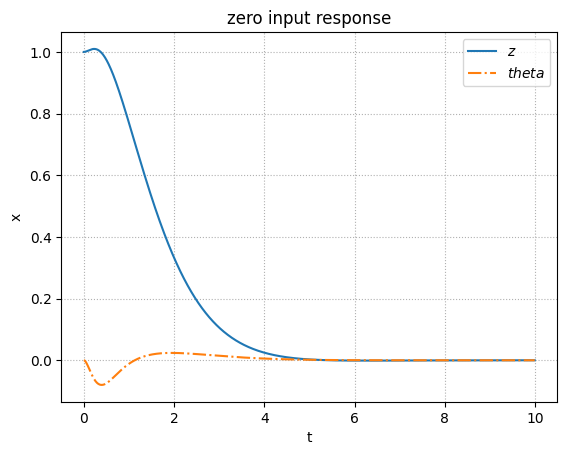

In [ ]:
# 初期値応答の描画
fig, ax = plt.subplots()
ax.plot(t, x[:, 0], label = '$z$')
ax.plot(t, x[:, 1], ls = '-.', label = '$theta$')
ax.set_title('zero input response')

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.grid(ls=':')
ax.legend(loc='best')
plt.show()